In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1: Disparity

## a) Disparity equation

$$ \frac{x_1}{f} = \frac{p_x}{p_z}, \frac{-x_2}{f} = \frac{T - p_x}{p_z} $$

$$ d = x_1 - x_2 = \frac{f p_x}{p_z} + \frac{f(T - p_x)}{p_z} = \frac{fT}{p_z} $$

When the object is close, disparity is large, when it is far away, it is small.

## b) Plotting disparity

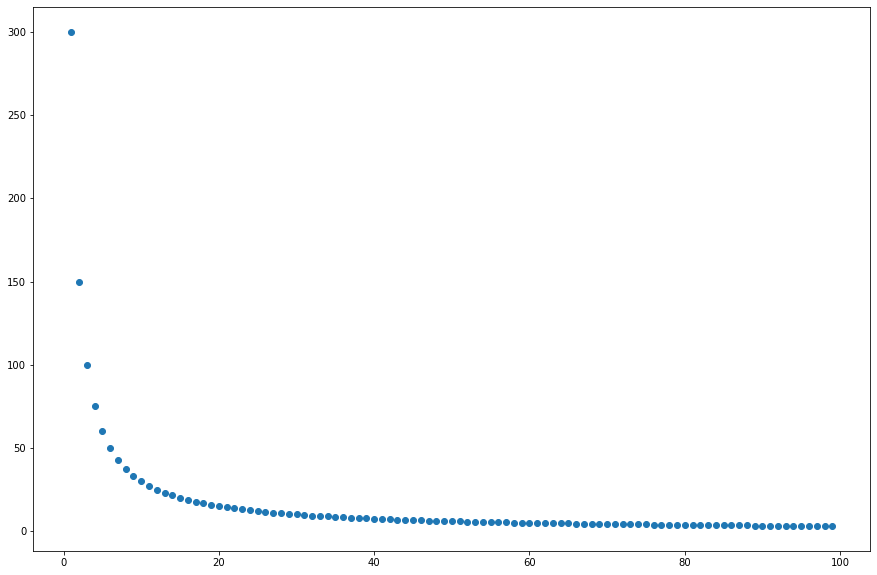

In [15]:
def disparity_example(f = 2.5, T = 120):
	pz = np.arange(1, 100)
	disp = f * T / pz
	plt.figure(figsize=(15, 10))
	plt.scatter(pz, disp)
	plt.show()

disparity_example()

## c) Specific case

$$ f = 2.5mm $$
$$ T = 120mm $$
$$ pw = 0.0074mm $$

$$ x_1 = 300 $$
$$ x_2 = 550 $$

$$ pw(x_1 - x_2) = \frac{fT}{p_z} <=> p_z = \frac{fT}{pw(x_1 - x_2)} $$

$$ p_{x_1} = \frac{2.5 * 120}{0.0074 * (550 - 300)} = 162.1mm = 0.162m $$
$$ p_{x_2} = \frac{2.5 * 120}{0.0074 * (550 - 540)} = 4054.05mm = 4.054m $$

# Exercise 2: Fundamental matrix, epipoles, epipolar lines

## Analytically

$$
x_1 = [300, 120, 1]^T \\
x_2 = [300, 170, 1]^T
$$

$$ F = \begin{bmatrix} 
0 & 0 & 0.002 \\
0 & 0 & −0.012 \\
−0.001 & 0.011 & −0.085
\end{bmatrix} \\ $$


$$ Fx_1 = [\frac{1}{500}, \frac{-3}{250}, \frac{187}{200}]^T $$
$$ Fx_2 = [\frac{1}{500}, \frac{-3}{250}, \frac{297}{200}]^T $$

## a) Function fundamental_matrix

In [69]:
from a5_utils import normalize_points, draw_epiline

In [84]:
def fundamental_matrix(points1, points2):
	pnorm1, T1 = normalize_points(points1)
	pnorm2, T2 = normalize_points(points2)
	A = []
	for p1, p2 in zip(pnorm1, pnorm2):
		A.append([p1[0] * p2[0], p1[0] * p2[1], p1[0], p1[1] * p2[0], p1[1] * p2[1], p1[1], p2[0], p2[1], 1])
	
	_, _, V = np.linalg.svd(A)
	Ft = V.T[:,-1].reshape(3,3)
	Uf, Df, Vf = np.linalg.svd(Ft)
	Df[-1] = 0
	F = (Uf * Df) @ Vf
	F = T2.T @ F.T @ T1
	return F

## b) Testing the function

In [85]:
house_points = np.array(open('data/epipolar/house_points.txt', 'r').read().split()).reshape(-1,4).astype(np.float64)
house_points_1 = house_points[:,0:2]
house_points_2 = house_points[:,2:4]
house_points_F = fundamental_matrix(house_points_1, house_points_2)
print(house_points_F)

[[-8.85211824e-07 -5.61591880e-06  1.94310952e-03]
 [ 9.39281870e-06  6.16883199e-07 -1.20066302e-02]
 [-1.20308414e-03  1.10370070e-02 -8.53173359e-02]]


In [63]:
house1 = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2GRAY)
house2 = cv2.cvtColor(cv2.imread('data/epipolar/house2.jpg'), cv2.COLOR_BGR2GRAY)

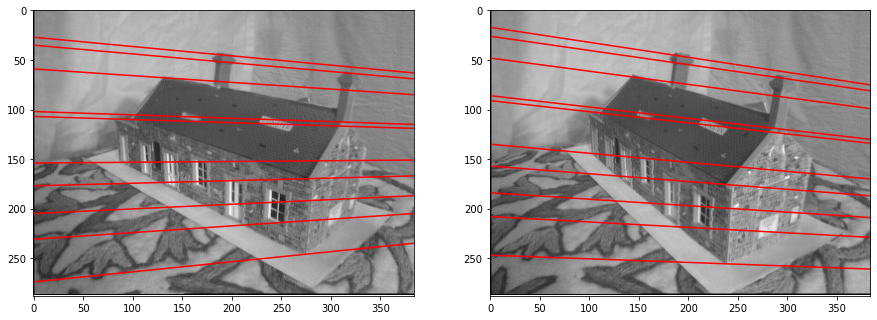

In [77]:
plt.figure(figsize=(15, 10))
plt.subplot(1,2,1), plt.imshow(house1, cmap='gray')
h, w = house1.shape
for px, py in house_points_2:
	e = np.array([px, py, 1])
	l = house_points_F.T @ e
	draw_epiline(l, h, w)

plt.subplot(1,2,2), plt.imshow(house2, cmap='gray')
h, w = house2.shape
for px, py in house_points_1:
	e = np.array([px, py, 1])
	l = house_points_F @ e
	draw_epiline(l, h, w)
plt.show()

## c) Reprojection error